In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler


import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

from DHO import ReservoirComputing
from HEB import Heb_func

# Model and training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
device = "cpu"
# device_RC = "cpu"
device_RC = device
print(f"the device used for the RC was: {device_RC}")
print(f"the device used for the Hebbian was: {device}")

model_save_folder = r"..."
sr = 20e3

# Model Parameters
n_nodes = 64
input_size = 128  # for the number of mel bands (default is 128)
output_size = 50 #num of classes for the ESC

model = ReservoirComputing(n_nodes, input_size, output_size,
                           alpha_0=1, gamma_0=0.1, omega_0=0.5,
                           device=device_RC)

criterion = nn.CrossEntropyLoss().to(device_RC)
optimizer = optim.Adam([
    {'params': model.Wih.parameters(), 'lr': 5e-4},
    {'params': model.Who.parameters(), 'lr': 1e-4}
])

#HEBBIAN parameters
h = 0.1
c = 0
c_rate = 0.5
sigma = -1
lr_h = 1e-4
p = 5
ps = 0.1

# Training Loop
num_epochs = 50
loss_hist = []
clip_value = 1
losses = 0
hist = []
acc = []
f1 = []
delta_norms = []

#load the data

data = torch.load(r"...")

mel_train = data['mel_tensors']
mel_test = data['mel_test']
labels_train = data['labels_tensor']
labels_test = data['labels_test']

print(len(mel_train))

#save the model

name = f'model_{c_rate}_{n_nodes}_{lr_h * 1000}_{sr/1000}_ESC.pt'


model_save_path = os.path.join(model_save_folder, name)

scalar = GradScaler()


for epoch in range(num_epochs):

    model.train()
    for i, (audio, label) in enumerate(zip(mel_train, labels_train)):

        audio = audio.to(device_RC)
        label = label.to(device_RC)

        optimizer.zero_grad()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        x_t = torch.zeros(n_nodes).to(device_RC)
        y_t = torch.zeros(n_nodes).to(device_RC)

        x_h = []
        y_h = []

        c = int((audio.t()[0].size(0)) * c_rate)

        with autocast():
            for t in range(audio.t()[0].size(0)):
                wave_value = audio[t]
                output, x_t, y_t = model(x_t, y_t, h, wave_value)

                #HEBBIAN

                if t>=c:
                    x_h.append(x_t[0])
                    y_h.append(y_t[0])
                    X_h = torch.stack(x_h)
                    Y_h = torch.stack(y_h)
                    x_heb = X_h.t()
                    y_heb = Y_h.t()

                    delta_w = Heb_func(sigma, lr_h, p, ps, x_heb,x_heb, n_nodes)

                    model.Whh.weight.data += delta_w
                    
                    delta_norm = torch.linalg.norm(delta_w.detach())
                    delta_norms.append(delta_norm.item() / torch.norm(model.Whh.weight.data))
            loss = criterion(output, label.view(1))
            losses += loss.item()
            loss.backward()
            optimizer.step()

        checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': loss
}
    torch.save(checkpoint, model_save_path)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {losses:.4f}')
    hist.append(losses)
    losses = 0 


    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for audio, label in zip(mel_test, labels_test):
            x_t = torch.zeros(n_nodes).to(device_RC)
            y_t = torch.zeros(n_nodes).to(device_RC)

            for t in range(audio.size(0)):
                wave_value = audio[t]
                output, x_t, y_t = model(x_t, y_t, h, wave_value)

            _, predicted = torch.max(output.data, 1)
            all_preds.append(predicted.item())
            all_labels.append(label.item())

    accuracy = accuracy_score(all_labels, all_preds)
    fscore = f1_score(all_labels, all_preds, average='weighted')

    acc.append(accuracy)
    f1.append(fscore)


    print(f"Accuracy on test set after epoch {epoch+1}: {accuracy:.4f}")
    print(f"F1 Score on test set after epoch {epoch+1}: {fscore:.4f}")

    model.train()

cuda
the device used for the RC was: cpu
the device used for the Hebbian was: cpu
2000
Epoch [1/50], Loss: 7623.1676
Accuracy on test set after epoch 1: 0.1925
F1 Score on test set after epoch 1: 0.1698
Epoch [2/50], Loss: 6602.9301
Accuracy on test set after epoch 2: 0.2475
F1 Score on test set after epoch 2: 0.2261
Epoch [3/50], Loss: 6143.6133
Accuracy on test set after epoch 3: 0.2900
F1 Score on test set after epoch 3: 0.2751
Epoch [4/50], Loss: 5805.9370
Accuracy on test set after epoch 4: 0.3100
F1 Score on test set after epoch 4: 0.2929
Epoch [5/50], Loss: 5529.4834
Accuracy on test set after epoch 5: 0.3350
F1 Score on test set after epoch 5: 0.3251
Epoch [6/50], Loss: 5268.7745
Accuracy on test set after epoch 6: 0.3700
F1 Score on test set after epoch 6: 0.3645
Epoch [7/50], Loss: 5030.9532
Accuracy on test set after epoch 7: 0.4025
F1 Score on test set after epoch 7: 0.3990
Epoch [8/50], Loss: 4810.3728
Accuracy on test set after epoch 8: 0.4350
F1 Score on test set after e

KeyboardInterrupt: 

In [ ]:
#load the model and restart training

###############################################

import os
import torch
import torch.nn as nn
import torch.optim as optim


import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

from DHO import ReservoirComputing
from HEB import Heb_func

# Model and training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
device = "cpu"
# device_RC = "cpu"
device_RC = device
print(f"the device used for the RC was: {device_RC}")
print(f"the device used for the Hebbian was: {device}")

model_save_folder = r"..."
sr = 20e3

# Model Parameters
n_nodes = 64
input_size = 128  # for the number of mel bands (default is 128)
output_size = 50

model = ReservoirComputing(n_nodes, input_size, output_size,
                           alpha_0=1, gamma_0=0.1, omega_0=0.5,
                           device=device_RC)

criterion = nn.CrossEntropyLoss().to(device_RC)
optimizer = optim.Adam([
    {'params': model.Wih.parameters(), 'lr': 5e-4},
    {'params': model.Who.parameters(), 'lr': 1e-4}
])

#HEBBIAN parameters
h = 0.1
c = 0
c_rate = 0.5
sigma = -1
lr_h = 1e-4
p = 5
ps = 0.1



checkpoint = torch.load(r'...')
model.load_state_dict(checkpoint['model_state_dict'])

cuda
the device used for the RC was: cpu
the device used for the Hebbian was: cpu


<All keys matched successfully>

In [ ]:
from torch.cuda.amp import autocast, GradScaler


# Training Loop
num_epochs = 50
loss_hist = []
clip_value = 1
losses = 0
hist = []
acc = []
f1 = []
delta_norms = []

#load the data

data = torch.load(r"...")

mel_train = data['mel_tensors']
mel_test = data['mel_test']
labels_train = data['labels_tensor']
labels_test = data['labels_test']

print(len(mel_train))

#save the model

name = f'model_{c_rate}_{n_nodes}_{lr_h * 1000}_{sr/1000}_ESC_r1.pt'


model_save_path = os.path.join(model_save_folder, name)

scalar = GradScaler()


for epoch in range(num_epochs):

    model.train()
    for i, (audio, label) in enumerate(zip(mel_train, labels_train)):

        audio = audio.to(device_RC)
        label = label.to(device_RC)

        optimizer.zero_grad()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        x_t = torch.zeros(n_nodes).to(device_RC)
        y_t = torch.zeros(n_nodes).to(device_RC)

        x_h = []
        y_h = []

        c = int((audio.t()[0].size(0)) * c_rate)

        with autocast():
            for t in range(audio.t()[0].size(0)):
                wave_value = audio[t]
                output, x_t, y_t = model(x_t, y_t, h, wave_value)

                #HEBBIAN

                if t>=c:
                    x_h.append(x_t[0])
                    y_h.append(y_t[0])
                    X_h = torch.stack(x_h)
                    Y_h = torch.stack(y_h)
                    x_heb = X_h.t()
                    y_heb = Y_h.t()

                    delta_w = Heb_func(sigma, lr_h, p, ps, x_heb,x_heb, n_nodes)

                    model.Whh.weight.data += delta_w
                    
                    delta_norm = torch.linalg.norm(delta_w.detach())
                    delta_norms.append(delta_norm.item() / torch.norm(model.Whh.weight.data))
            loss = criterion(output, label.view(1))
            losses += loss.item()
            loss.backward()
            optimizer.step()

        checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': loss
}
    torch.save(checkpoint, model_save_path)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {losses:.4f}')
    hist.append(losses)
    losses = 0 


    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for audio, label in zip(mel_test, labels_test):
            x_t = torch.zeros(n_nodes).to(device_RC)
            y_t = torch.zeros(n_nodes).to(device_RC)

            for t in range(audio.size(0)):
                wave_value = audio[t]
                output, x_t, y_t = model(x_t, y_t, h, wave_value)

            _, predicted = torch.max(output.data, 1)
            all_preds.append(predicted.item())
            all_labels.append(label.item())

    accuracy = accuracy_score(all_labels, all_preds)
    fscore = f1_score(all_labels, all_preds, average='weighted')

    acc.append(accuracy)
    f1.append(fscore)


    print(f"Accuracy on test set after epoch {epoch+1}: {accuracy:.4f}")
    print(f"F1 Score on test set after epoch {epoch+1}: {fscore:.4f}")

    model.train()

2000
Epoch [1/50], Loss: 2746.6835
Accuracy on test set after epoch 1: 0.6825
F1 Score on test set after epoch 1: 0.6801
Epoch [2/50], Loss: 2673.7671
Accuracy on test set after epoch 2: 0.6925
F1 Score on test set after epoch 2: 0.6953
Epoch [3/50], Loss: 2625.0181
Accuracy on test set after epoch 3: 0.6975
F1 Score on test set after epoch 3: 0.6978
Epoch [4/50], Loss: 2562.0801
Accuracy on test set after epoch 4: 0.7100
F1 Score on test set after epoch 4: 0.7076
Epoch [5/50], Loss: 2508.7294
Accuracy on test set after epoch 5: 0.6975
F1 Score on test set after epoch 5: 0.6950
Epoch [6/50], Loss: 2436.8433
Accuracy on test set after epoch 6: 0.7050
F1 Score on test set after epoch 6: 0.7068
Epoch [7/50], Loss: 2386.4271
Accuracy on test set after epoch 7: 0.6975
F1 Score on test set after epoch 7: 0.6980


KeyboardInterrupt: 

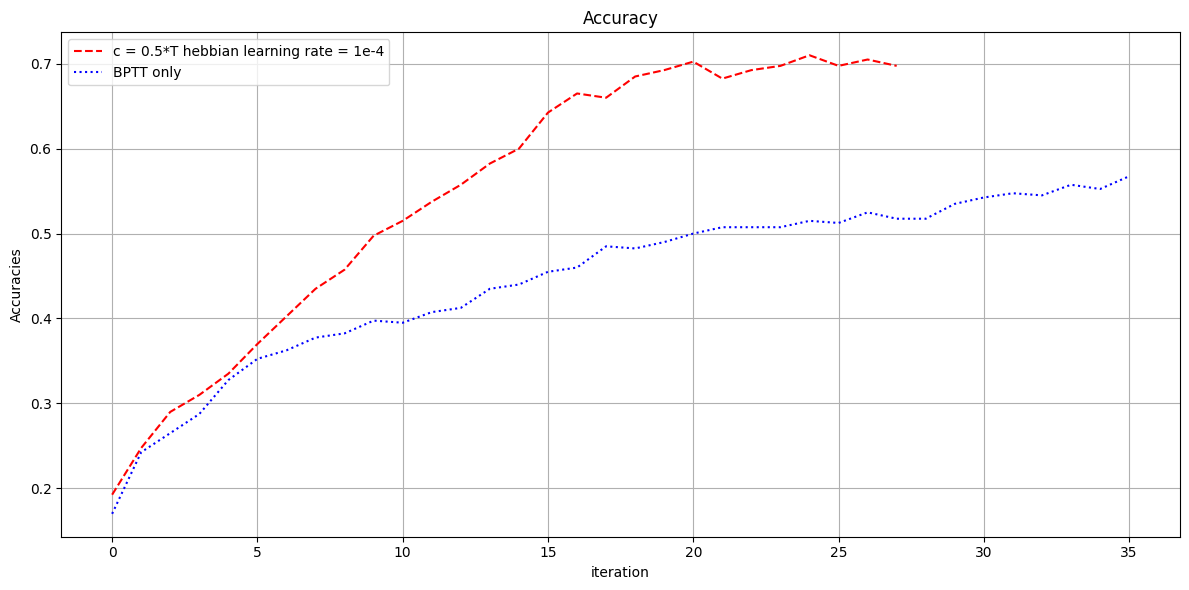

In [8]:
acc_h =  [0.1925, 0.2475, 0.29, 0.31, 0.335, 0.37, 0.4025, 0.435, 0.4575, 0.4975, 0.515, 0.5375, 0.5575, 0.5825, 0.6, 0.6425, 0.665, 0.66, 0.685, 0.6925, 0.7025 , 0.6825, 0.6925, 0.6975, 0.71, 0.6975, 0.705, 0.6975]
acc_b = [0.17, 0.2425, 0.265, 0.2875, 0.3275, 0.3525, 0.3625, 0.3775, 0.3825, 0.3975, 0.395, 0.4075, 0.4125, 0.435, 0.44, 0.455, 0.46, 0.485, 0.4825, 0.49, 0.5, 0.5075, 0.5075, 0.5075, 0.515, 0.5125, 0.525, 0.5175, 0.5175, 0.535, 0.5425, 0.5475, 0.545, 0.5575, 0.5525, 0.5675]

colors = ['red', 'blue' , 'green', 'purple']
line_style = ['--' , ':' , '--' , '--']

plt.figure(figsize=(12, 6))

for i, (y, color, label , linestyle) in enumerate(
    zip([acc_h , acc_b], colors, ['c = 0.5*T hebbian learning rate = 1e-4','BPTT only',  'c = 0.5*T hebbian learning rate = 5e-4' , 'c = 0 hebbian learning rage = 1e-4'] , line_style)):
    plt.plot(y, label=label, color=color , linestyle = linestyle)
plt.xlabel('iteration')
plt.ylabel('Accuracies')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

loss = [2746.6834876840057, 2673.7670774647117, 2625.018091286278, 2562.08011327187, 2508.7294258225274, 2436.843313017509, 2386.4270861032383]